 # SPP
![image-resnet](./photo/sppnet.png)


## 1D SPPnet

In [1]:
import numpy as np
import os
import torch
from torch.utils import data
from torch.utils.data import Dataset
from torch import nn

In [2]:
from DataAndModel import read_data, transfrom, npdata, spatial_pyramid_pooling

In [3]:
train_img,train_label = read_data('./data/data/energy_train.npy','./data/data/label_train.npy', transfrom(reshape=(1,-1)))
test_img,test_label = read_data('./data/data/energy_test.npy','./data/data/label_test.npy', transfrom(reshape=(1,-1)))

train_data = npdata(train_img, train_label)
test_data = npdata(test_img, test_label)


In [4]:
batch_size = 256
train_it = data.DataLoader(train_data, batch_size, shuffle=True, num_workers=0)
test_it = data.DataLoader(test_data, batch_size, num_workers=0)

In [5]:
def cnn_1d_block(conv_arch):
    block = []
    for input_num, output_num, kernel, stride, padding in conv_arch:
        block.append(nn.Conv1d(input_num, output_num, kernel_size=kernel, stride=stride, padding=padding))
    return block


In [6]:
conv_arch = [
    [  1, 128, 4, 1, 2],
    [128, 128, 3, 2, 1],
    [128, 256, 2, 1, 1],
    [256, 256, 2, 1, 1],
    [256, 512, 2, 1, 1]
]
pool_size = [1, 2, 3]

In [7]:
net = nn.Sequential(
    *cnn_1d_block(conv_arch), 
    spatial_pyramid_pooling(pool_size),
    nn.Linear(3072, 512), nn.ReLU(),
    nn.Linear(512, 256), nn.ReLU(),
    nn.Linear(256, 5)
    )

In [8]:
X = torch.rand(size=(1, 1, 127))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Conv1d output shape:	 torch.Size([1, 128, 128])
Conv1d output shape:	 torch.Size([1, 128, 64])
Conv1d output shape:	 torch.Size([1, 256, 65])
Conv1d output shape:	 torch.Size([1, 256, 66])
Conv1d output shape:	 torch.Size([1, 512, 67])
spatial_pyramid_pooling output shape:	 torch.Size([1, 3072])
Linear output shape:	 torch.Size([1, 512])
ReLU output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 256])
ReLU output shape:	 torch.Size([1, 256])
Linear output shape:	 torch.Size([1, 5])


loss 0.093, train acc 0.968, test acc 0.858
11976.0 examples/sec on cuda:0


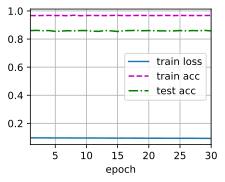

In [14]:
import TrainAndDraw as T
lr, num_epochs = 0.001, 30
T.train(net, train_it, test_it, num_epochs, lr, T.try_gpu(), 'SPP', isini=1)